In [1]:
"""A zero-dimensional photochemical model. Adapted from MATLAB code by 
R. Wordsworth 3/8/20."""    

# define system constants
S2DAY = 1/(3600*24) # 1 day [s]

# Import the necessary packages and modules
import numpy as np
from numpy import exp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
    
# define all classes

class ChemSpecies:
    """Contains definitions for each chemical species"""    
    def __init__(self,index,name,elements,molmass,behaviour):
        self.index       = index # index number
        self.name        = name # name
        self.elements    = elements # elements tally (integer array)
        self.molmass     = molmass # molar mass [g/mol] (real)
        self.behaviour   = behaviour # 'active' or 'passive' (character)


class Reaction:
    """Contains definitions for each reaction"""    
    def __init__(self,formula):
        self.formula   = formula # reaction formula
        self.reactants = formula.split('=')[0].split('+') # reactants
        self.products  = formula.split('=')[1].split('+') # products


class PhotoReaction(Reaction):
    """Contains definitions for each photoreaction"""    
    def __init__(self,formula,J):
        Reaction.__init__(self,formula)
        self.rateconst = J # reaction rate constant [1/s]
        
        
class TwoBodyReaction(Reaction):
    """Contains definitions for each two-body reaction"""    
    def __init__(self,formula,k_fn):
        Reaction.__init__(self,formula)
        self.k_fn=k_fn
    def calc_rate(self,T):
        self.rateconst = self.k_fn(T) # reac. rate constant [1/molec./cm3]
        
        
class ThreeBodyReaction(Reaction):
    """Contains definitions for each three-body reaction"""    
    def __init__(self,formula,k_fn):
        Reaction.__init__(self,formula)
        self.k_fn=k_fn
    def calc_rate(self,T,psi_tot):
        self.rateconst = self.k_fn(T)*psi_tot # reac. rate constant [1/molec./cm3]


class ReactionNetwork:
    """
    Contains definitions for an entire reaction network:
    chemical reaction network matrices A, q.
    In a pure chemical system, (psi_i)_t = A_ij*psi_j + q_ijk*psi_j*psi_k,
    where psi is the concentration in molecules/cm3 of each species.
    A is for unimolecular reactions, q is for 2- and 3-body reactions
    """    
    def __init__(self,n_species):
        self.A = np.zeros((n_species,n_species))
        self.q = np.zeros((n_species,n_species,n_species))

    def add_reactions(self,reactions,species_dict):
        for i in range(1,len(reactions)+1):
            self.add_reaction(reactions['R'+str(i)],species_dict)

    def add_reaction(self,reaction,species_dict):
        active = lambda species: species.behaviour=='active'
        # only 'active' species have their concentrations updated
        r1 = species_dict[reaction.reactants[0]] # 1st reactant
        p1 = species_dict[reaction.products[0]] # 1st product   
        # the 'ir1' etc. variables are simply here to make the code cleaner
        ir1 = r1.index
        ip1 = p1.index
        
        if(isinstance(reaction,PhotoReaction)): # by default 1 reactant, 2 products
            p2 = species_dict[reaction.products[1]] # 2nd product
            ip2 = p2.index
            self.A[ir1,ir1] -= active(r1)*reaction.rateconst
            self.A[ip1,ir1] += active(p1)*reaction.rateconst
            self.A[ip2,ir1] += active(p2)*reaction.rateconst
            
        elif(isinstance(reaction,TwoBodyReaction)): # by default 2 reactants, 2 products
            r2 = species_dict[reaction.reactants[1]] # 2nd reactant
            p2 = species_dict[reaction.products[1]] # 2nd product
            ir2 = r2.index
            ip2 = p2.index           
            self.q[ir1,ir1,ir2] -= active(r1)*reaction.rateconst
            self.q[ir2,ir1,ir2] -= active(r2)*reaction.rateconst
            self.q[ip1,ir1,ir2] += active(p1)*reaction.rateconst
            self.q[ip2,ir1,ir2] += active(p2)*reaction.rateconst
            if len(reaction.products) == 3:
                p3 = species_dict[reaction.products[2]] # 3rd product
                ip3 = p3.index                    
                self.q[ip3,ir1,ir2] += active(p3)*reaction.rateconst                
                    
        elif(isinstance(reaction,ThreeBodyReaction)): # by default 2 reactants, 1 product
            r2 = species_dict[reaction.reactants[1]] # 2nd reactant
            ir2 = r2.index
            self.q[ir1,ir1,ir2] -= active(r1)*reaction.rateconst
            self.q[ir2,ir1,ir2] -= active(r2)*reaction.rateconst
            self.q[ip1,ir1,ir2] += active(p1)*reaction.rateconst
            
        else:
            sys.exit('Error, reaction type unrecognized!')

    def dpsidt(self,t,psi):
        """
        Inputs:
        t : time (not used, but needed for in-built python solver)
        psi : float64 array of length n_species
            chemical species number concentration [molecs/cm3].

        Output:
        dpsidt : float64 array of length n_species
            time derivative of chemical species number concentration [molecs/cm3/s].
        """

        # (psi_i)_t = A_ij*psi_j + q_ijk*psi_j*psi_k
        # (psi_i)_t = A_ij*psi_j + u_ij*psi_j
        # c.f. e.g. Brasseur & Jacob Ch. 6.
      
        AA = np.zeros((n_species,n_species))
        AA[:,:] = self.A[:,:]
        q_lay = self.q[:,:,:]        
        u = np.dot(q_lay,psi)
        dpsidt = np.dot(AA,psi) + np.dot(u,psi)

        return dpsidt

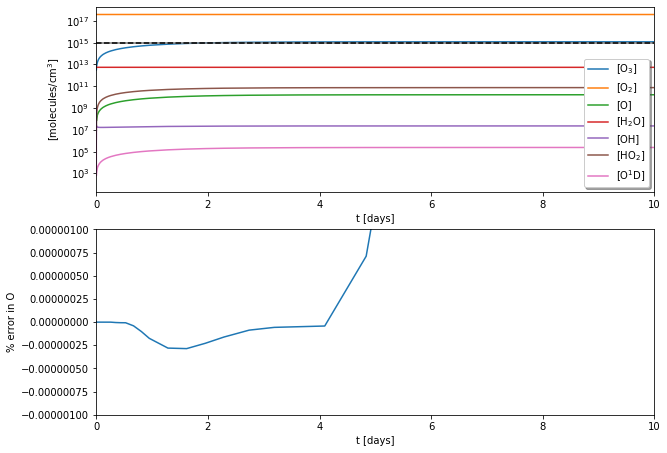

In [19]:
#### main code starts here  #####

# create list of elements
# (currently unused; could be used to do automated stoichiometry checks)
e_names=['C', 'H', 'O', 'N']

# create dictionary of species objects
species_dict={
    'O3':  ChemSpecies(0,'O3', [0, 0, 3, 0],48.0,'active'), 
    'O2':  ChemSpecies(1,'O2', [0, 0, 2, 0],32.0,'active'), 
    'O':   ChemSpecies(2,'O',  [0, 0, 1, 0],16.0,'active'), 
    'H2O': ChemSpecies(3,'H2O',[0, 2, 1, 0],18.0,'active'),
    'OH':  ChemSpecies(4,'OH', [0, 1, 1, 0],17.0,'active'),
    'HO2': ChemSpecies(5,'HO2',[0, 1, 2, 0],33.0,'active'),
    'O1D': ChemSpecies(6,'O1D',[0, 0, 1, 0],16.0,'active'),
    'M':   ChemSpecies(7,'M',  [0, 0, 0, 2],28.0,'static'),
    }

# create dictionary of reaction objects
# reactions taken from Chapter 10 Jacob and constants from kinetics.nist.gov
reactions={
    'R1': PhotoReaction('O2+hv=O+O',1e-8),
    #'R12': PhotoReaction('O2+hv=O1D+O1D',2.7e-5), #From my calculations assuming top atm flux and sea-level air density
    'R2': ThreeBodyReaction('O+O2=O3',lambda T: 6e-34*(T/298.)**(-2.3)),
    'R3': PhotoReaction('O3+hv=O2+O',1e-2),
    'R9':PhotoReaction('O3+hv=O2+O1D',4.1e-3), #from Jacob prob 10.3; 45km, T=263K, na=5e16;higher [O3], lower T at 20km
    'R10':TwoBodyReaction('O1D+M=O+M',lambda T: 1.79e-11*(T/298.)**(109/T)), #Used NIST data for N2+O1D->N2+O
    'R4': TwoBodyReaction('O3+O=O2+O2',lambda T: 8.0e-12*(T/298.)*exp(-2060/T)),
    #'R5': TwoBodyReaction('H2O+O=OH+OH',lambda T: 1.62e-10*(T/298.)*exp(65/T)), # k ~ 10**-10
    'R5':TwoBodyReaction('H2O+O1D=OH+OH',lambda T: 2.19e-10*(T/298.)), # k ~ 10**-10
    'R6': TwoBodyReaction('OH+O3=HO2+O2',lambda T: 1.70e-12*(T/298.)*exp(-940/T)), # k ~ 10**-14
    'R7': TwoBodyReaction('HO2+O3=OH+O2+O2',lambda T: 1.97e-16*(T/298.)**4.57*exp(-690/T)), # k ~ 10**-17
    'R8': TwoBodyReaction('OH+HO2=H2O+O2',lambda T: 4.80e-11*(T/298.)*exp(250/T)), # k ~ 10**-10
    }

# determine number of species and reactions
n_species = len(species_dict)
n_reactions = len(reactions)

# set atmospheric temperature [K]
T = 200.0

# define initial conditions for species concentrations
# some numbers taken from Problem 10.5 of Jacob.
# @45km: n = 4.1e16, T = 270 K; @20km: n = 1.8e18, T = 200K
psi_tot = 1.8e18 # total air number density [molec./cm3]
psi0 = np.zeros(n_species) # size of psi0 = number of species

psi0[0] = 3.0e12 # 3.0e12 @ 30 km and 20 km, ~2e11 @ 45 km; Chapter 10 Jacob
psi0[1] = 0.21*psi_tot
psi0[2] = 3.0e7 #3.0e7 @ 30 km, ~1.0e9 @ 45 km (rough agreement bwtn Ch. 10 values, 10.2 calcs, and chem solver)
psi0[3] = 3e-6*psi_tot #Chiou et al 1997 Journal of geophys. - approx. value; relatively const. throughout strat.
psi0[4] = 1.4e6 #Li et al 2018, Nature (1.1e5 @ 10-12km) - rough agreement w/ Wennberg et al 1995; 1.4e6 @ 20km, 4.1e6 @ 40km
psi0[5] = 8.5e6 #30 km; problem 10.5 of Jacob (rough agreement w/ Wennber et al 1995); 5.4e6 @ 18km, ? 45km
psi0[6] = 1.0e9
psi0[7] = 0.78*psi_tot

# calculate non-photochemical reaction rates (could make this a loop)
# if rxn is 3 body: reaction.calc_rate(T,psi_tot), elif rxn != Photo: reaction.calc_rate(T). IDK which attribute of Reaction gives rxn type.
#for reaction in reactions:
    #if reaction['']
reactions['R2'].calc_rate(T,psi_tot)
reactions['R10'].calc_rate(T)
reactions['R4'].calc_rate(T)
reactions['R5'].calc_rate(T)
reactions['R6'].calc_rate(T)
reactions['R7'].calc_rate(T)
reactions['R8'].calc_rate(T)
#reactions['R11'].calc_rate(T)

# create reaction network object and add all the reactions to it
reaction_network = ReactionNetwork(n_species)
reaction_network.add_reactions(reactions,species_dict)

# solve the system using in-built scipy solve_ivp function
time_tot = 10.0/S2DAY
sol = solve_ivp(reaction_network.dpsidt, [0, time_tot], psi0, method='BDF', dense_output=False)
psi = sol.y

# calculate error diagnostics
initial_O = 0
final_O = 0
for species in species_dict:
    initial_O += species_dict[species].elements[2]*psi0[species_dict[species].index]
    final_O += species_dict[species].elements[2]*psi[species_dict[species].index]
err_in_O = initial_O - final_O

# calculate expected O3 abundance analytically (c.f. Jacob eqn. 10.8)
C_O3_analytic = (1e-8*1e-33/(1e-2*8.e-12*exp(-2060/T)))**0.5*0.21*psi_tot**(3/2)

# display code results
fig = plt.figure(figsize=(10, 7.5))
ax1 = fig.add_subplot(2,1,1)
ta=sol.t*S2DAY
plt.semilogy(ta,psi[0,:],ta,psi[1,:],ta,psi[2,:],ta,psi[3,:],ta,psi[4,:],ta,psi[5,:],ta,psi[6,:],ta,0*ta + C_O3_analytic)
plt.semilogy(ta,0*ta + C_O3_analytic,'k--')
plt.axis([0, time_tot*S2DAY, 1e-17*psi_tot, psi_tot])
plt.xlabel('t [days]')
plt.ylabel('[molecules/cm$^3$]')
plt.legend(['[O$_3$]', '[O$_2$]','[O]', '[H$_2$O]', '[OH]', '[HO$_2$]', '[O$^1$D]'], shadow=True)

# display error in O conservation
ax2 = fig.add_subplot(2,1,2)
plt.plot(ta,1e2*err_in_O/initial_O)
plt.axis([0, time_tot*S2DAY, -1e-6, 1e-6])
plt.xlabel('t [days]')
plt.ylabel('% error in O')
plt.show()

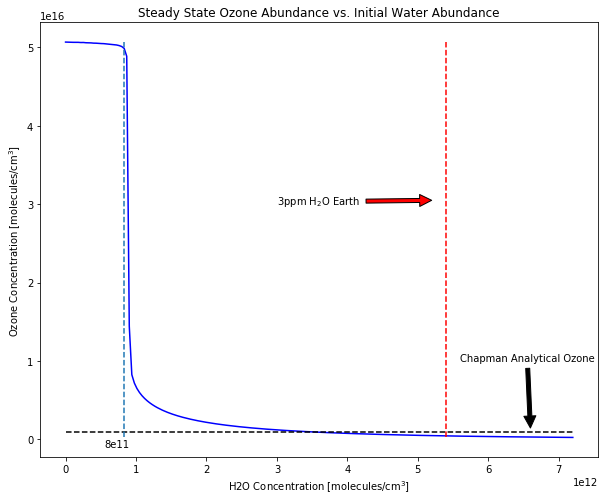

In [26]:
#active H2O, O1D prod. from O3 and O2 photolysis, O1D and O oxidation of H2O to OH, collision-induced relaxation
psi_H2O = np.linspace(1e-12*psi_tot, 4e-6*psi_tot,200)
psi_O3 = []

for initial_concn in (psi_H2O):
    psi0[3] = initial_concn
    sol = solve_ivp(reaction_network.dpsidt, [0, time_tot], psi0, method='BDF', dense_output=False)
    psi = sol.y
    psi_O3.append(psi[0][-1])

psi_H2O_ppm = 1e6*psi_H2O/psi_tot

%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8))
x = psi_H2O
y = psi_O3
ax.plot(x, y, 'b-')
ax.plot((min(x),max(x)),(C_O3_analytic, C_O3_analytic),'k--')
ax.plot((3e-6*psi_tot,3e-6*psi_tot),(min(y),max(y)),'r--')
ax.plot((8.3e11,8.3e11),(min(y),max(y)),'--')
ax.set_xlabel('H2O Concentration [molecules/cm$^3$]')
ax.set_ylabel('Ozone Concentration [molecules/cm$^3$]')
ax.set_title('Steady State Ozone Abundance vs. Initial Water Abundance')
#ax.annotate('Chapman Analytical Ozone', xy=(0.99e15, 0.95e15), xytext=(0.75e15, 0.7e15),
            #arrowprops=dict(facecolor='black', shrink=0.05))
#ax.annotate('3ppm H$_2$O Earth', xy=(3e-5, 0.5e15), xytext=(0.5e15, 0.5e15),
            #arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('Chapman Analytical Ozone', xy=(6.6e12, 0.1e16), xytext=(5.6e12, 1.0e16),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('3ppm H$_2$O Earth', xy=(5.25e12, 3.05e16), xytext=(3e12, 3.0e16),
            arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('8e11', xy=(5.5e11,-1e15), xytext=(5.5e11,-1e15))
fig.savefig("ozone_vs_water_all.pdf")

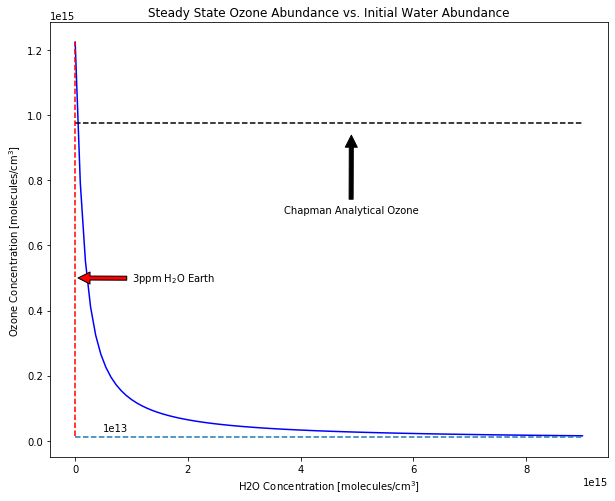

In [41]:
#active H2O, O1D prod. from O3 photolysis, O1D oxidation of H2O to OH, collision-induced relaxation
psi_H2O = np.linspace(1e-9*psi_tot, 5.0e-3*psi_tot,100)
psi_O3 = []

for initial_concn in (psi_H2O):
    psi0[3] = initial_concn
    sol = solve_ivp(reaction_network.dpsidt, [0, time_tot], psi0, method='BDF', dense_output=False)
    psi = sol.y
    psi_O3.append(psi[0][-1])

psi_H2O_ppm = 1e6*psi_H2O/psi_tot

%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8))
x = psi_H2O
y = psi_O3
ax.plot(x, y, 'b-')
ax.plot((min(x),max(x)),(C_O3_analytic, C_O3_analytic),'k--')
ax.plot((3e-6*psi_tot,3e-6*psi_tot),(min(y),max(y)),'r--')
ax.plot((min(x),max(x)),(1e13,1e13),'--') #asymptote
ax.set_xlabel('H2O Concentration [molecules/cm$^3$]')
ax.set_ylabel('Ozone Concentration [molecules/cm$^3$]')
ax.set_title('Steady State Ozone Abundance vs. Initial Water Abundance')
ax.annotate('Chapman Analytical Ozone', xy=(4.9e15, 0.95e15), xytext=(3.7e15, 0.7e15),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('3ppm H$_2$O Earth', xy=(3e-5, 0.5e15), xytext=(1e15, 0.49e15),
            arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('1e13', xy=(0.5e15,3e13), xytext=(0.5e15,3e13))
fig.savefig("ozone_vs_water.pdf")

#### Follow up: 
- What are relevant H20 ranges to consider?

### Notes

__[R1]__   $ O_{2} + h\nu \longrightarrow 2 O $

__[R2]__   $ O + O_{2} + M \longrightarrow O_{3} + M $

__[R3]__   $ O_{3} + h\nu \longrightarrow O_{2} + O $

__[R4]__   $ O + O_{3} \longrightarrow 2 O_{2} $

__[R5]__   $ H_{2}O + O \longrightarrow 2 OH $

__[R6]__   $ O_{3} + OH \longrightarrow HO_{2} + O_{2} $

__[R7]__   $ HO_{2} + O_{3} \longrightarrow OH + 2 O_{2} $

__[R8]__   $ HO_{2} + OH \longrightarrow H_{2}O + O_{2} $

Rate constants for R5-R8 (HOx cycle) are roughly 10^-10, 10^-14, 10^-17, and 10^-10 respectively.

__Conditions for the following plots: T = 270 K and air number density 4.1e16 corresponding to altitude = 45km.__

- All active w/o Chapman
    - O depletes in about one second (R5 is fast).
    - OH increases dramatically in less than a second (3-4 orders of mag) due to rapid oxidation of water by O (R5 fast). OH then decreases roughly linearly and reaches steady state after about a minute; it is used up in R6 and R8 (fast).
    - HO2 increases slightly and achieves steady state in fewer than 10 seconds. As R6 proceeds, it slows down quickly b/c it produces HO2 to react in R8 (much faster than R6) which also consumes OH used in R6. R8 consumes HO2. Thus, the production of HO2 in R6 leads to faster R8; R8 consumes the OH needed for R6, slowing R6.
    - 
    
<img src="all_active.png">

- O static w/o Chapman
    - Something very strange happens around 0.05 days. The functions appear to all be discontinuous at this time.
    - All species but O, OH, and O2 decrease roughly linearly until about 0.04 days, then continue to decline linearly at a slower rate than before. The functions are discontinuous again from around 0.2 days until 1 day where steady state is reached.
    - Why is OH static?
    
<img src="O_static.png">

- All active w/ Chapman
    - Ozone steady state 2 orders of magnitude lower than w/o Chapman
    - OH produced quickly - jumps several orders of magnitude in seconds. A bit strange that [OH] is so much higher than other species given its high reactivity.
    - O3 steady state ~ 2 orders of magnitude lower than analytical value.
    - HO2 and O3 do a funny dance together.
    - What's happening with water?

<img src="all_active_chapman.png">

- Static OH w/ Chapman
    - Ozone steady state at the analytic ozone abundance from Jacob 10.8.
    - Water abundance plummets quickly (R5 is fast).
    - Why is steady state O3 abundance lower when [OH] is fixed than when it's active? -> b/c [OH] increases several orders of magnitude when active.

<img src="staticOH_chapman.png">

- Static H20 w/ Chapman
    - Compare to all active w/ Chapman. Ozone drops 4-5 orders of magnitude and OH increases about 10 orders of magnitude after 10 days. This is expected if water is static to continue generating OH and destroy ozone. Fixing O increases OH several more orders of magnitude with little impact on ozone.
    - [HO2] also decreases rapidly, not suprisingly given R8 is fast and OH is fixed.

<img src="staticH2O_chapman.png">

- Major questions:
    - What's going on with the static O model w/o Chapman?
    - Why is O3 steady state orders of mag lower w/ Chapman added?
    

- Next Steps:
    - Can we compare analytical result to numerical solve? Force OH constant – write analytic expression for outcome of one reaction.
    - Resolve altitude dependency?

- All active w/ O1D in R5
    - O3 approaches analytical value at equilibrium.
    - O3 and O behavior appears remarkably similar to simulation with only Chapman alone and no HOx nor O1D.
    
<img src='active_O1D_45km.png'>

### Conditions for the following plots: T = 200 K and air number density = 1.8e18 corresponding to altitude = 20km. Singlet oxygen is also included in the model.

#### Including singlet oxygen in the model is in response to unexpectedly high hydroxyl radical levels seen above. This suggests OH sinks are insufficient or sources are overproducing.

- All active, includes N2 collision-induced O1D -> O3P relaxation (R3) and O1D oxidation of water to OH (R5).
    - Similar behavior as the analogous plot at 45km but over longer timescale (~1 order of mag).
    - The addition of singlet oxygen in R3 and R5 brought OH steady state levels down. Oxidation of water by O1D is actualy slightly faster than by O3P. The conversion of O1D to O3P in R3 must limit this effect.
    - __Follow up: include oxidation of water by both O1D and O3P simultaneously. This may drive OH back up__
    
<img src='active_O1D_20km.png'>

- Same as above except with singlet oxygen production from ozone photolysis.
    - O1D levels look unrealistically high but OH is still reasonable.
    - __Follow up: calculate photolysis rate constant using flux wavelength function at 20 km.__

<img src='active_O1d_R3.png'>

- All active, this simulation includes singlet oxygen production in oxygen photolysis (R1) and in ozone photolysis (R3), as well as O1D oxidation of water (R5) and collision-induced relaxation (R3).
    - Note change in time scale from above.
    - Note that singlet oxygen generation from O2 photolysis is modeled here for top of atm flux and sea level air density. At 20km, flux and density will be much lesser. __Altitude flux data is needed to better approximate the photolysis rate constant.__ A more accurate estimate may drive the ozone and OH levels down.

<img src='active_O1D_R1_20km.png'>

- Same as above but with only triplet oxygen in R5 rather than singlet oxygen
    - Ozone steady state closer to analytical but hydroxyl levels high
    - __Compare to plot above. Very surprising that the difference between O1D and O3P in R5 causes such a drastic difference in OH steady state concentration (over 5 orders of magnitude). Rate constants for these two R5 reactions are within a factor of 2. It follows that the added OH brings O3 down a couple orders of magnitude.__

<img src='active_O1D_R1_noR5.png'>

In [54]:
C_O3_analytic

977686550096564.2

In [ ]:
9.8e14